# Quick intro to `pytorch`

This notebook presents a quick intro to the typical building blocks you need to train a paramtrized function via gradient descent

## `pytorch` as a tools for learning functions
`pytorch` lets you code functions. It comes with very similar primitives and function names as `numpy`, but has two extra things: It can seamlessly switch its location to GPUs and it can compute the gradient of any array manipulation you come up with without any effort on your side.

Let's take a look

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
def f(x):
    return x ** 2

In [3]:
x = torch.arange(20., requires_grad=True)

In [4]:
y = f(x)

In [5]:
y

tensor([  0.,   1.,   4.,   9.,  16.,  25.,  36.,  49.,  64.,  81., 100., 121.,
        144., 169., 196., 225., 256., 289., 324., 361.],
       grad_fn=<PowBackward0>)

In [6]:
x

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.], requires_grad=True)

In [7]:
y.grad_fn(torch.ones(20))

tensor([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24., 26.,
        28., 30., 32., 34., 36., 38.], grad_fn=<MulBackward0>)

In [8]:
2 * x

tensor([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24., 26.,
        28., 30., 32., 34., 36., 38.], grad_fn=<MulBackward0>)

We see two things:
1. The gradient was computed correctly to 2x
2. Even when computing 2x we would get the possibility of having a gradient. Sometimes we don't care and would like to avoid using extra memory. In these cases we can `detach` our tensor from a graph of gradient computations

In [9]:
2 * x.detach()

tensor([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24., 26.,
        28., 30., 32., 34., 36., 38.])

## Neural networks as functions that store some parameters

As seen above, `pytorch` naturally keeps track of gradients of the operations one does. For parametrized functions such as neural networks it is useful to gather all the parameters that can vary within an object, to have them all together.

To make such an object, we can employ a python `class` structure and benefit from that fact that `pytorch` has templates for this, specifically `torch.nn.Module`. In this structure, our code would look something like this:

```python
class MyParametrizedFunction(torch.nn.Module):
    
    def __init__(self, ... all the specifications/parameters it needs ...):
        super(MyParametrizedFunction, self).__init__()
        # ... do something to initialize the parameters
        # ...
    
    def forward(self, x):
        # all the computations leading from input `x` to
        # the function output
```

Very often, the specifications we input to such a function are shapes and sizes of the arrays of parameters. To be able to keep some order in the `__init__` function, and to avoid unexpected behavior, it is useful to split the storage of specifications and the building of the arrays, making the structure look more like this:

```python
class MyParametrizedFunction(torch.nn.Module):
    
    def __init__(self, ... all the specifications/parameters it needs ...):
        super(MyParametrizedFunction, self).__init__()
        # store all the inputs/specs/parameters
        
        self.build()  # call build to add any extra internal structure
    
    def build(self):
        # ... do something to initialize/create the parameters
        # ...
    
    def forward(self, x):
        # all the computations leading from input `x` to
        # the function output
```


### Let's encapsulate a linear function!
This exercise is purely pedagogical since `pytorch` already has linear/affine units like this, but let's create one anyway:

In [10]:
class LinearFunction(torch.nn.Module):
    def __init__(self, n_input=1, n_output=1, bias=True):
        super(LinearFunction, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.bias = bias
    
        self.build()
    
    def build(self):
        self.matrix = torch.nn.Parameter(torch.randn(self.n_input, self.n_output))
        if self.bias:
            self.bias_vector = torch.nn.Parameter(torch.randn(self.n_output))
    
    def forward(self, x):
        # assume x of shape (batch, n_input)
        output = torch.mm(x, self.matrix)
        if self.bias:
            output = output + self.bias_vector
        
        return output

Let's test it out:

In [11]:
lf = LinearFunction(n_input=1, n_output=1)

on some data spaced between 0 and 1

In [12]:
x = torch.arange(0, 1, .01)[:, np.newaxis]
#x

In [13]:
y = lf(x)

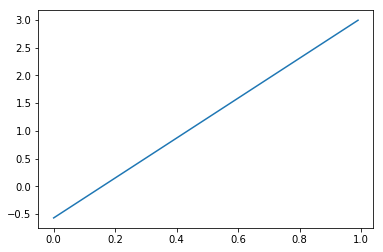

In [14]:
plt.plot(x.detach().numpy().ravel(), y.detach().numpy().ravel())

Absolutely no surprise: It's a linear function!

### Some quick ways of creating a neural network

`pytorch` offers the possibility to create virtually any function from its components. Most standard neural networks actually take a very simple form of stacked layers. Creating these has been facilitated in neural network packages in general, and specifically in `pytorch`. Concatenating layers using `torch.nn.Sequential` is one of these facilitations. Let's take a look: 

In [15]:
net_one_hidden = torch.nn.Sequential(
    torch.nn.Linear(1, 1),
    torch.nn.ReLU(),
    torch.nn.Linear(1, 1)
)

We just created a 1-hidden layer neural network of one dimension

In [16]:
x2 = torch.arange(-3, 3, .01)[:, np.newaxis]
y2 = net_one_hidden(x2)

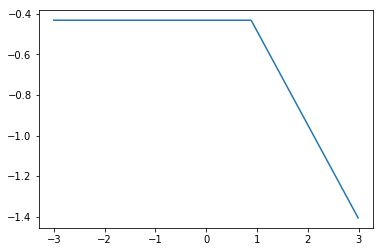

In [17]:
plt.plot(x2.detach().numpy().ravel(), y2.detach().numpy().ravel())

Let's make this a bit more interesting by adding some hidden dimensions into which the linear layer can project:

In [18]:
net_one_hidden_better = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1)
)

In [19]:
x3 = torch.arange(-1, 1, .01)[:, np.newaxis]
y3 = net_one_hidden_better(x3)

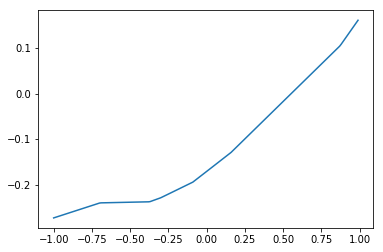

In [20]:
plt.plot(x3.detach().numpy().ravel(), y3.detach().numpy().ravel())

How about more layers:

In [21]:
net_one_hidden_even_better = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1)
)

In [22]:
x4 = torch.arange(-1, 1, .01)[:, np.newaxis]
y4 = net_one_hidden_even_better(x4)

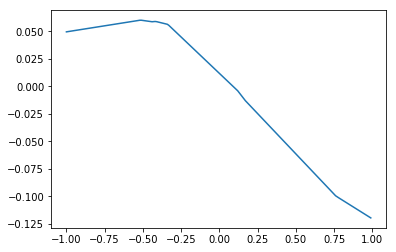

In [23]:
plt.plot(x4.detach().numpy().ravel(), y4.detach().numpy().ravel())

**Exercise 01:** Write a function that takes a series of integers as input, indicating neural network layer sizes, and initializes a neural network with precisely those sizes, and a `ReLU` nonlinearity *between* each layer (don't put one at the end)

In [26]:
# %load solutions/pytorch/solution01.txt
# %load https://raw.githubusercontent.com/SFdS-atelier-3/block-1/master/solutions/pytorch/solution01.txt

In [27]:
network = create_neural_network((1, 10, 1))

In [28]:
y5 = network(x4)

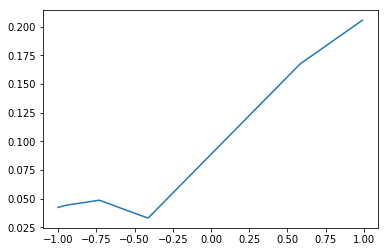

In [29]:
plt.plot(x4.detach().numpy().ravel(), y5.detach().numpy().ravel())

### How do we get these to fit a function we like?

The success of neural networks comes from their ability to fit arbitrary functions given enough data.

But we have to give them hints on what we want it to do. We do this by providing examples and also by specifying an error.

Let us take a look at how this is done.

First we need to know which function we would like to learn. Let's create several, and restrict ourselves to functions living on the interval $(-1, 1)$

In [30]:
def f1(x):
    return x ** 2

In [31]:
def f2(x):
    return np.maximum(x, 0)  # relu

In [32]:
def f3(x):
    return 2 * x

In [33]:
def f4(x, f=2.):
    return np.sin(2 * np.pi * f * x)

In [34]:
x = torch.arange(-1, 1, 0.001, requires_grad=False)[:, np.newaxis]

In [35]:
y1 = f1(x).detach()
y2 = f2(x).detach()
y3 = f3(x).detach()
y4 = f4(x).detach()

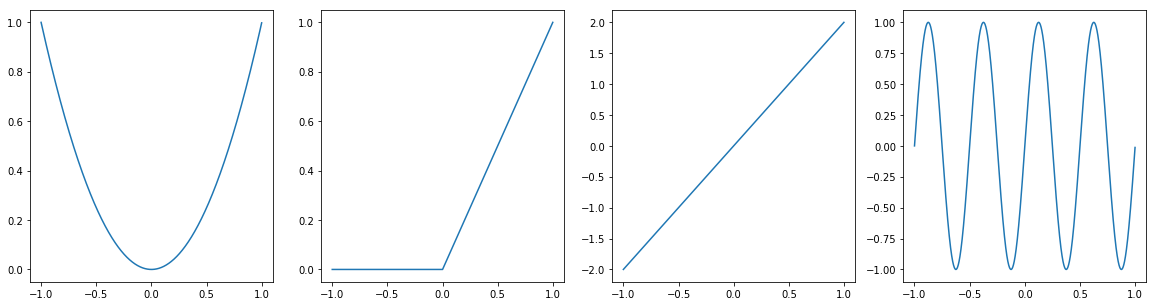

In [36]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.plot(x.numpy().ravel(), y1.numpy().ravel())
plt.subplot(1, 4, 2)
plt.plot(x.numpy().ravel(), y2.numpy().ravel())
plt.subplot(1, 4, 3)
plt.plot(x.numpy().ravel(), y3.numpy().ravel())
plt.subplot(1, 4, 4)
plt.plot(x.numpy().ravel(), y4.numpy().ravel())

Ok, now that we have data (`x`) and a target (`y`) let's take a look at how neural networks are generally trained.

## Training neural networks with `pytorch`

To train a neural network, we need
- a network
- data (here `x`)
- target (here `y`)
- an *optimization criterion* or *loss* or *error function*
- an *optimizer* that attempts to minimize the error by gradient descent

Let's create our network:

In [37]:
net = create_neural_network((1, 100, 100, 100, 1))

### The optimization criterion
The optimization criterion quantifies the similiarity between what the network outputs for the data and what we expect the network to output for the data.

With category labels, this is often the *cross-entropy* loss, which we will get to later.

For this application here we will use the *mean squared error*:

$$MSE(p, y) = \frac{1}{N}\|p - y\|^2$$

In [38]:
from torch.nn import MSELoss

In [39]:
mse = MSELoss()

In [40]:
mse(torch.ones(10), torch.ones(10) * 5)

tensor(16.)

### The optimizer
Once we have a loss function and its gradient, we need a mechanism to take steps in order to reduce it. *Stochastic Gradient Descent* is the method of choice here. As a first choice, the optimizer `Adam` is useful to achieve quite good convergence.

To instantiate an optimizer, we need to give it the parameters of the network that we want optimize:

In [41]:
from torch.optim import Adam, SGD

In [42]:
optimizer = Adam(net.parameters())
#optimizer = SGD(net.parameters(), lr=0.001)

### One optimization cycle
Let's do one round of an optimization:

In [43]:
indices = torch.from_numpy(np.random.permutation(len(x))[:100]) # to choose some random values
indices

tensor([ 945,  560, 1697,  420, 1098, 1884,  191,   28, 1060,  730,  662,  189,
         274,  368,  223, 1836, 1040,  881, 1594, 1195, 1279, 1666, 1891, 1175,
        1499, 1335, 1177, 1431,  486,   68,  669,  522,  593, 1035, 1360, 1775,
         910, 1397, 1812, 1430,   92,  571,   18,  793, 1041,  554,  540, 1511,
         475,  165,  848,  764,  161,  248, 1472, 1557, 1947, 1215,  498,  838,
        1039, 1219,  300, 1831,   87,  604,  954,  687, 1096,  846, 1290,  238,
        1185, 1854,  759,  230, 1925, 1995, 1674,  479,  844, 1642,  797, 1171,
        1977, 1425, 1410,  608, 1733, 1232, 1707,  396, 1662, 1681,  859,  988,
        1167, 1542,  263,  929])

In [44]:
x_batch = x[indices]
y1_batch = y1[indices]

In [45]:
prediction = net(x_batch)

In [46]:
loss = mse(prediction, y1_batch)
loss

tensor(0.2028, grad_fn=<MseLossBackward>)

In [47]:
# compute all gradients
loss.backward()

In [48]:
# have the optimizer take a step
optimizer.step()

After this cycle, let's check the loss:

In [49]:
mse(net(x_batch), y1_batch)

tensor(0.1559, grad_fn=<MseLossBackward>)

We observe that it is slightly lower!

### A function for training one epoch
An *epoch* is one pass through the dataset. It is useful to write a function that can perform one pass over an epoch

In [50]:
def train_epoch(network, data, criterion, optimizer):
    losses = []
    for x_batch, y_batch in data:
        prediction = network(x_batch)
        loss = criterion(prediction, y_batch)
        losses.append(loss.detach().cpu().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return np.array(losses)

### A useful iterator for data batches
`pytorch` has some built-in objects to make data batches, which we will use:

In [51]:
from torch.utils.data import Dataset, DataLoader

First we make a dataset out of our x and y.

In [52]:
data1 = DataLoader(list(zip(x, y1)), batch_size=32, shuffle=True)

### Using the `train_epoch` function
Now we can try out the loss function and observe the evolution of the training

In [53]:
losses = train_epoch(net, data1, mse, optimizer)

In [54]:
losses.mean()

0.032880932

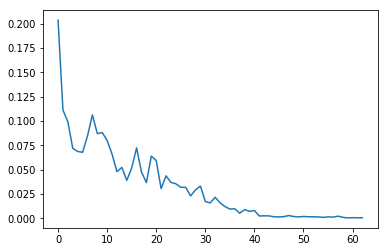

In [55]:
plt.plot(losses)

In [56]:
predictions = net(x).detach().cpu().numpy()

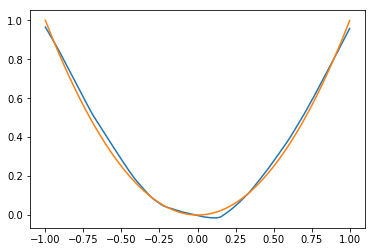

In [57]:
plt.plot(x.numpy(), predictions)
plt.plot(x.numpy(), y1.numpy())

### A function that iterates over epochs

Usually neural networks need several passes over the data to fully train. We can automate this, and the creation of the optimizer and the criterion, inside another function, which we will call `train_mse_adam`

In [58]:
def train_mse_adam(network, dataset, n_epochs=10):
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(network.parameters())
    
    all_losses = []
    
    for e in range(n_epochs):
        
        losses = train_epoch(network, dataset, criterion, optimizer)
        all_losses.append(losses)
    
    return np.array(all_losses)

In [59]:
net = create_neural_network((1, 10, 1))

In [60]:
all_losses = train_mse_adam(net, data1, 30)

In [61]:
all_losses.shape

(30, 63)

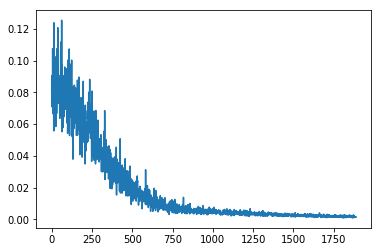

In [62]:
plt.plot(np.concatenate(all_losses))

In [63]:
prediction1 = net(x).detach().cpu().numpy()

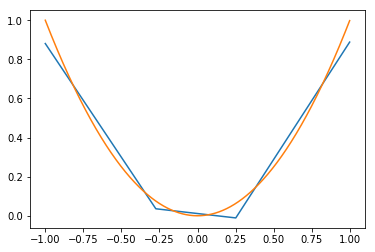

In [64]:
plt.plot(x.numpy(), prediction1)
plt.plot(x.numpy(), y1.numpy())

**Exercise 02:** Train networks for the 3 other functions. How big do they need to be? For y4, does it vary with the sinusoid frequency?

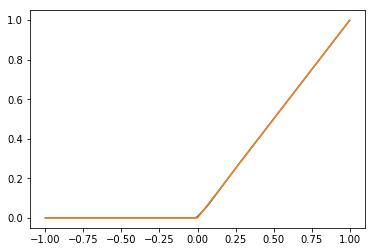

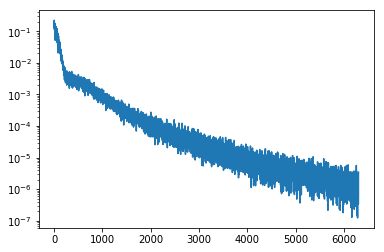

In [78]:
net2 = create_neural_network((1, 10, 1))

data2 = DataLoader(list(zip(x, y2)), batch_size=32, shuffle=True)

all_losses2 = train_mse_adam(net2, data2, 100)

prediction2 = net2(x).detach().cpu().numpy()

plt.plot(x.numpy(), prediction2)
plt.plot(x.numpy(), y2.numpy())
plt.figure()
plt.plot(np.concatenate(all_losses2))
plt.yscale('log')

In [ ]:
# %load solutions/pytorch/solution02.txt
# %load https://raw.githubusercontent.com/SFdS-atelier-3/block-1/master/solutions/pytorch/solution02.txt